# Neste trabalho, vamos analisar empréstimos imobiliários
##### Nossa base de dados compõe de um arquivo zipado de 166.13 MB (que dezipado chega a 1,5Gb). Nosso objetivo é prever se um determinado cliente irá dar calote no empréstimo ou não baseado. Vamos usar métodos de Deep Learning para buscar cumprir esse objetivo. Antes disso, devemos preparar nossa base de dados, que é o que faremos inicialmente. O link para a base de dados está aqui https://www.kaggle.com/datasets/deependraverma13/house-loan-data-analysis-deep-learning


In [1]:
# Importação das bibliotecas a serem utilizadas

import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from pathlib import Path
import datetime as dt
import time 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
# Código extra -> Definição de padrões de fonte nas figuras apresentadas
plt.rc('font', size=12)
plt.rc('axes', labelsize=12, titlesize=12)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Código extra -> Definição de padrões de visualização dos dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# Código extra -> Salvar as figuras no formato .png
IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
# Leitura do arquivo
# Caminho para o arquivo zipado
caminho_arquivo_zip = r'C:\Users\danie\OneDrive\Área de Trabalho\archive.zip' # O leitor desse documento deverá substituir esse
# caminho por onde escolheu salvar a base de dados

#Nome do arquivo CSV dentro do arquivo zip
nome_arquivo_csv = 'loan_data (1).csv'

# Extração o arquivo CSV do arquivo zip
with zipfile.ZipFile(caminho_arquivo_zip, 'r') as zip_ref:
    # Verificar se o arquivo CSV está presente no zip
    if nome_arquivo_csv in zip_ref.namelist():
        with zip_ref.open(nome_arquivo_csv) as csv_file:
            # Ler o arquivo CSV e armazenar na variável df
            df = pd.read_csv(csv_file,low_memory=False)

In [5]:
# Não temos informação sobre o significado de FLAGDOCUMENT ou EXTSOURCE, vamos retirar essas colunas para evitr maiores problemas
# Retiramos também a coluna de ID, pois ela não agregará em nada no nosso modelo futuro
df = df[df.columns.drop(list(df.filter(regex='FLAG_DOCUMENT_')))] 
df = df[df.columns.drop(list(df.filter(regex='EXT_SOURCE_')))] 
df = df.drop(['SK_ID_CURR'], axis=1)

## Lidando com dados faltantes

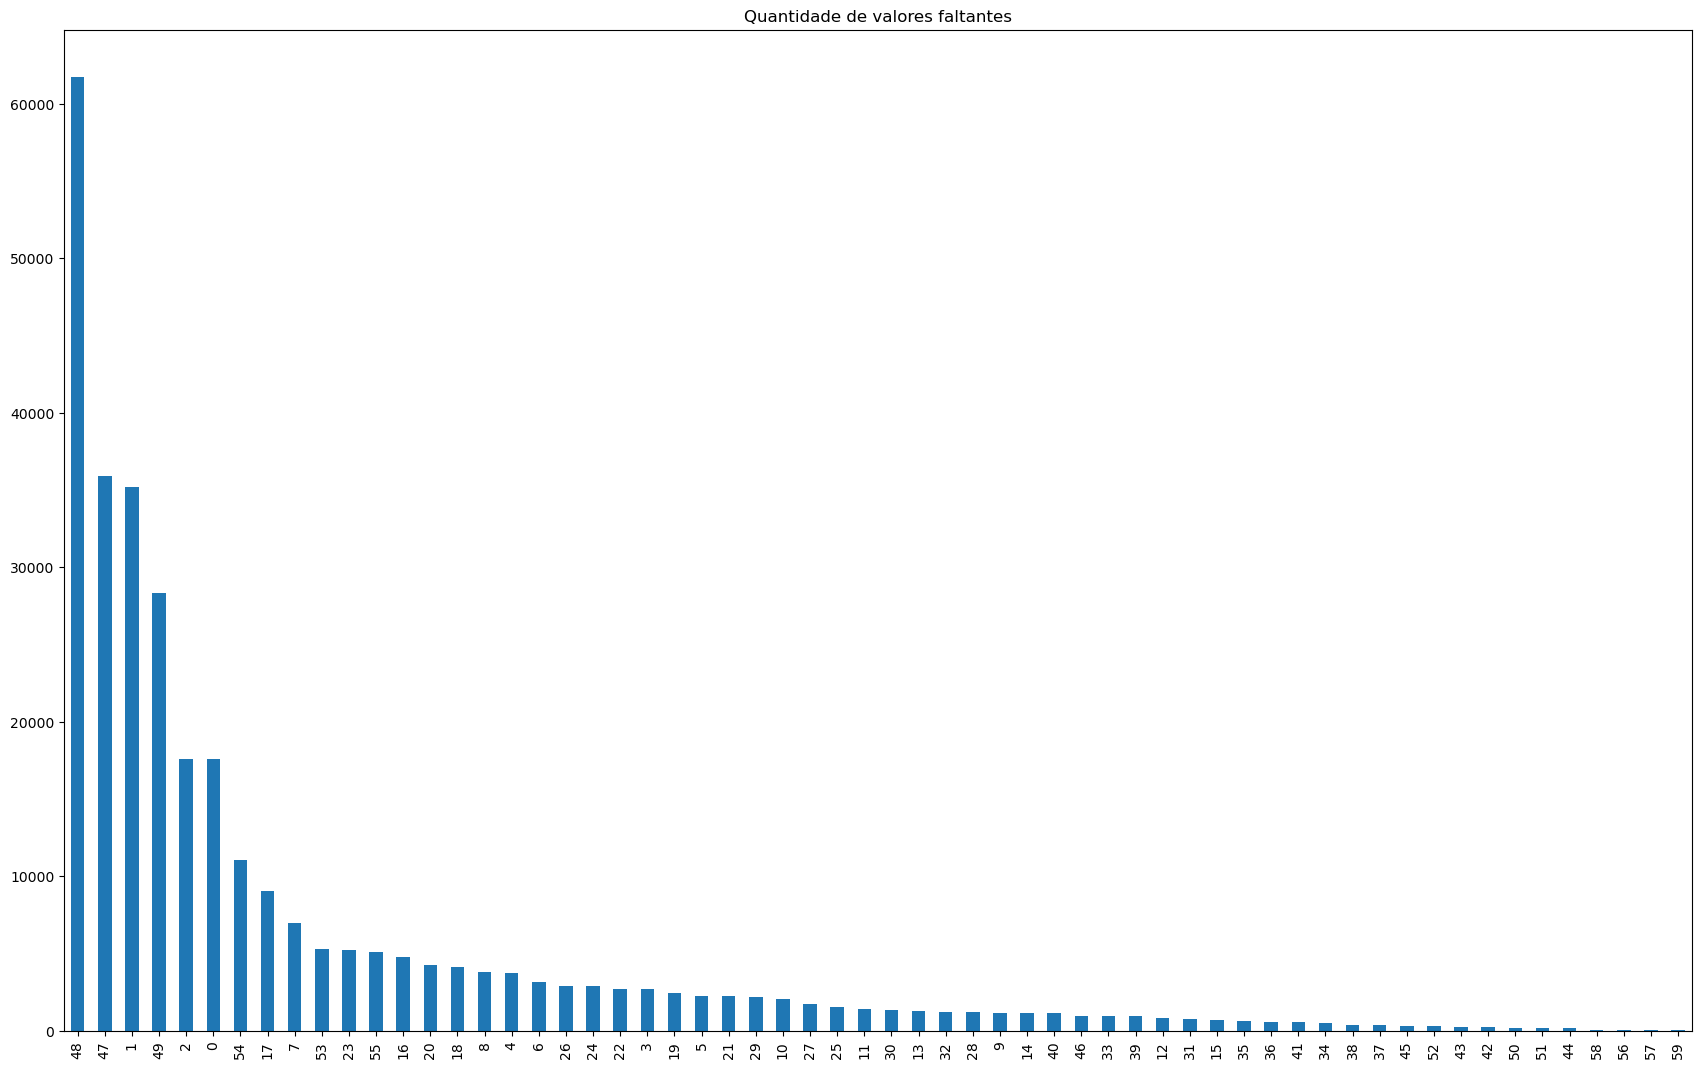

In [6]:
df.isna().sum(axis=1).value_counts().plot(
    kind="bar", title="Quantidade de valores faltantes", figsize = (21,13)
)
plt.show()

In [7]:
missing = df.isnull().sum()
100*missing/df.shape[0] # Números em porcentagem, para facilitar a visualização

TARGET                           0.000000
NAME_CONTRACT_TYPE               0.000000
CODE_GENDER                      0.000000
FLAG_OWN_CAR                     0.000000
FLAG_OWN_REALTY                  0.000000
CNT_CHILDREN                     0.000000
AMT_INCOME_TOTAL                 0.000000
AMT_CREDIT                       0.000000
AMT_ANNUITY                      0.003902
AMT_GOODS_PRICE                  0.090403
NAME_TYPE_SUITE                  0.420148
NAME_INCOME_TYPE                 0.000000
NAME_EDUCATION_TYPE              0.000000
NAME_FAMILY_STATUS               0.000000
NAME_HOUSING_TYPE                0.000000
REGION_POPULATION_RELATIVE       0.000000
DAYS_BIRTH                       0.000000
DAYS_EMPLOYED                    0.000000
DAYS_REGISTRATION                0.000000
DAYS_ID_PUBLISH                  0.000000
OWN_CAR_AGE                     65.990810
FLAG_MOBIL                       0.000000
FLAG_EMP_PHONE                   0.000000
FLAG_WORK_PHONE                  0

In [8]:
# Temos várias lacunas grandes no nosso dataset, por escolha, vamos excluir colunas com mais de 30% de dados faltantes.
# Com uma base de dados tão esburacada, nosso modelo não iria performar bem nessa parte.
missing = df.isnull().sum()
for col in missing[missing > 0.3].index.tolist():
    del df[col]

In [9]:
# Vamos verificar o tipo de dado em cada coluna e quantos dados diferentes temos em cada coluna
for x in df.columns:
    print(f"{x} --> {np.dtype(df[x]), df[x].nunique()}")

TARGET --> (dtype('int64'), 2)
NAME_CONTRACT_TYPE --> (dtype('O'), 2)
CODE_GENDER --> (dtype('O'), 3)
FLAG_OWN_CAR --> (dtype('O'), 2)
FLAG_OWN_REALTY --> (dtype('O'), 2)
CNT_CHILDREN --> (dtype('int64'), 15)
AMT_INCOME_TOTAL --> (dtype('float64'), 2548)
AMT_CREDIT --> (dtype('float64'), 5603)
NAME_INCOME_TYPE --> (dtype('O'), 8)
NAME_EDUCATION_TYPE --> (dtype('O'), 5)
NAME_FAMILY_STATUS --> (dtype('O'), 6)
NAME_HOUSING_TYPE --> (dtype('O'), 6)
REGION_POPULATION_RELATIVE --> (dtype('float64'), 81)
DAYS_BIRTH --> (dtype('int64'), 17460)
DAYS_EMPLOYED --> (dtype('int64'), 12574)
DAYS_REGISTRATION --> (dtype('float64'), 15688)
DAYS_ID_PUBLISH --> (dtype('int64'), 6168)
FLAG_MOBIL --> (dtype('int64'), 2)
FLAG_EMP_PHONE --> (dtype('int64'), 2)
FLAG_WORK_PHONE --> (dtype('int64'), 2)
FLAG_CONT_MOBILE --> (dtype('int64'), 2)
FLAG_PHONE --> (dtype('int64'), 2)
FLAG_EMAIL --> (dtype('int64'), 2)
REGION_RATING_CLIENT --> (dtype('int64'), 3)
REGION_RATING_CLIENT_W_CITY --> (dtype('int64'), 3)
WEE

### Devemos perceber que, apesar de algumas colunas serem numéricas, elas são puramente categóricas. 

In [10]:
# Vamos agora separar as colunas que são categóricas das que são puramente numéricas
# Vamos usar 10 valores distintos como ponto de corte para os casos de dúvida
# Nossas colunas numéricas são então
num = ['TARGET','CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','REGION_POPULATION_RELATIVE','DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION',
       'DAYS_ID_PUBLISH','HOUR_APPR_PROCESS_START']

# Nossas colunas de categoria, são as restantes
cat = [col for col in df.columns.values if col not in num]
for col in num:
    df[col] = (df[col].astype(float))

In [11]:
# Vamos ver algumas métricas estatísticas das colunas numéricas
df[num].describe()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,HOUR_APPR_PROCESS_START
count,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,0.080729,0.417052,1.687979e+05,5.990260e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.063419
std,0.272419,0.722121,2.371231e+05,4.024908e+05,0.013831,4363.988632,141275.766519,3522.886321,1509.450419,3.265832
min,0.000000,0.000000,2.565000e+04,4.500000e+04,0.000290,-25229.000000,-17912.000000,-24672.000000,-7197.000000,0.000000
25%,0.000000,0.000000,1.125000e+05,2.700000e+05,0.010006,-19682.000000,-2760.000000,-7479.500000,-4299.000000,10.000000
50%,0.000000,0.000000,1.471500e+05,5.135310e+05,0.018850,-15750.000000,-1213.000000,-4504.000000,-3254.000000,12.000000
75%,0.000000,1.000000,2.025000e+05,8.086500e+05,0.028663,-12413.000000,-289.000000,-2010.000000,-1720.000000,14.000000
max,1.000000,19.000000,1.170000e+08,4.050000e+06,0.072508,-7489.000000,365243.000000,0.000000,0.000000,23.000000


In [12]:
## Vamos visualizar como alguns dados estão correlacionados com nossa variável de interesse 'TARGET' para 
## facilitar nosso entendimento
corr_matrix = df[num].corr(numeric_only=True)
corr_matrix["TARGET"].abs().sort_values(ascending=False)*100 # Os valores abaixo estão em porcentagem!!!

TARGET                        100.000000
DAYS_BIRTH                      7.823931
DAYS_ID_PUBLISH                 5.145717
DAYS_EMPLOYED                   4.493166
DAYS_REGISTRATION               4.197486
REGION_POPULATION_RELATIVE      3.722715
AMT_CREDIT                      3.036929
HOUR_APPR_PROCESS_START         2.416583
CNT_CHILDREN                    1.918713
AMT_INCOME_TOTAL                0.398187
Name: TARGET, dtype: float64

In [13]:
# Por simplicidade, vamos separar 5 atributos com maior correlação para uma análise mais profunda
# Vamos selecionar apenas as colunas que possuem correlação maior que 5% em valor absoluto

top5 = ['DAYS_BIRTH','DAYS_ID_PUBLISH','DAYS_EMPLOYED','DAYS_REGISTRATION','REGION_POPULATION_RELATIVE']


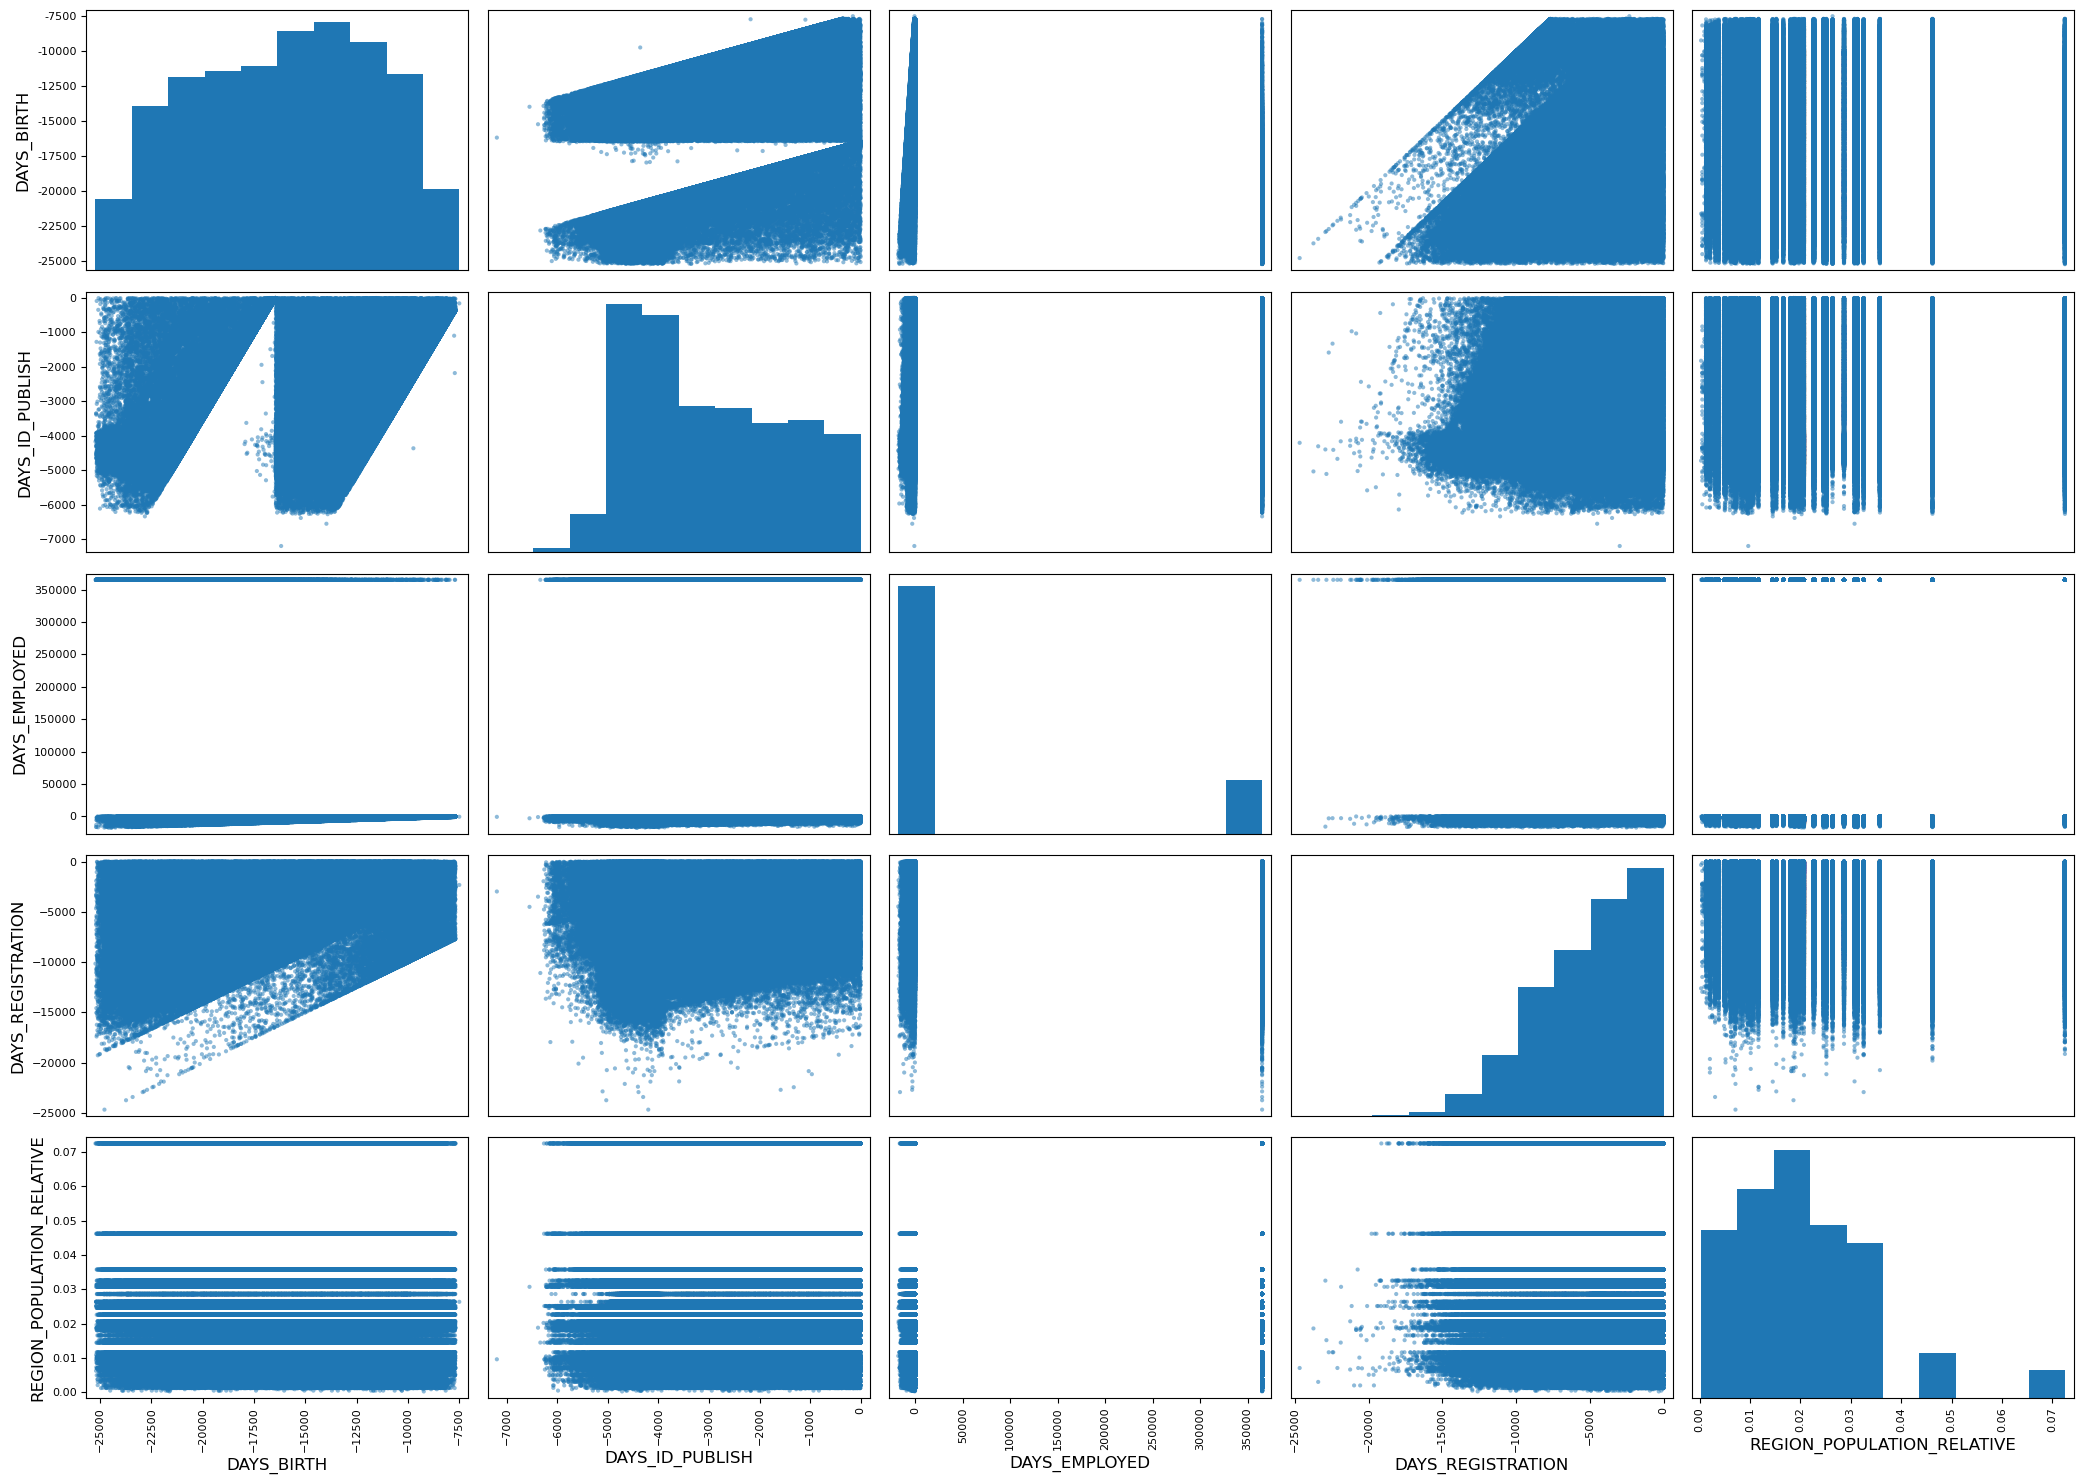

In [14]:
# Análise do top 5
scatter_matrix(df[top5], figsize=(21, 15))
save_fig("scatter_matrix_plot")  # extra
plt.show()

In [15]:
# A distribuição da variável 'DAYS_EMPLOYED' está um pouco fora do comum, vamos analisá-la mais a fundo
df["DAYS_EMPLOYED"].value_counts()

DAYS_EMPLOYED
 365243.0    55374
-200.0         156
-224.0         152
-230.0         151
-199.0         151
-212.0         150
-384.0         143
-229.0         143
-231.0         140
-215.0         138
-207.0         138
-216.0         137
-188.0         137
-196.0         136
-116.0         136
-222.0         135
-193.0         134
-195.0         133
-214.0         132
-254.0         131
-213.0         131
-201.0         130
-381.0         130
-233.0         128
-185.0         128
-194.0         127
-237.0         127
-184.0         126
-234.0         126
-209.0         125
-348.0         125
-241.0         124
-745.0         123
-137.0         123
-382.0         122
-139.0         122
-198.0         122
-238.0         122
-218.0         120
-240.0         120
-205.0         120
-191.0         120
-118.0         119
-223.0         119
-225.0         119
-181.0         118
-430.0         118
-244.0         118
-227.0         118
-268.0         117
-370.0         117
-133.0         11

In [16]:
# Percebemos no gráfico anterior que possivelmente temos um valor anômalo em torno de 350.000
# Nossa estratégia escolhida para lidar com valores faltantes será de substituição pela média dos outros valores
df['DAYS_EMPLOYED_NAN'] = (df["DAYS_EMPLOYED"]==365243).astype('int')
# Vamos agora trocar esses valores por NaN, e, depois, pela sua média

df['DAYS_EMPLOYED'].replace(365243.0, np.nan, inplace=True)
media = df['DAYS_EMPLOYED'].mean()
df['DAYS_EMPLOYED'].replace(np.nan, media , inplace=True)
# Vamos agora ver como a correlação ficou
df[num].corr(numeric_only = True)['TARGET'].abs().sort_values(ascending=False)*100

TARGET                        100.000000
DAYS_BIRTH                      7.823931
DAYS_EMPLOYED                   7.007472
DAYS_ID_PUBLISH                 5.145717
DAYS_REGISTRATION               4.197486
REGION_POPULATION_RELATIVE      3.722715
AMT_CREDIT                      3.036929
HOUR_APPR_PROCESS_START         2.416583
CNT_CHILDREN                    1.918713
AMT_INCOME_TOTAL                0.398187
Name: TARGET, dtype: float64

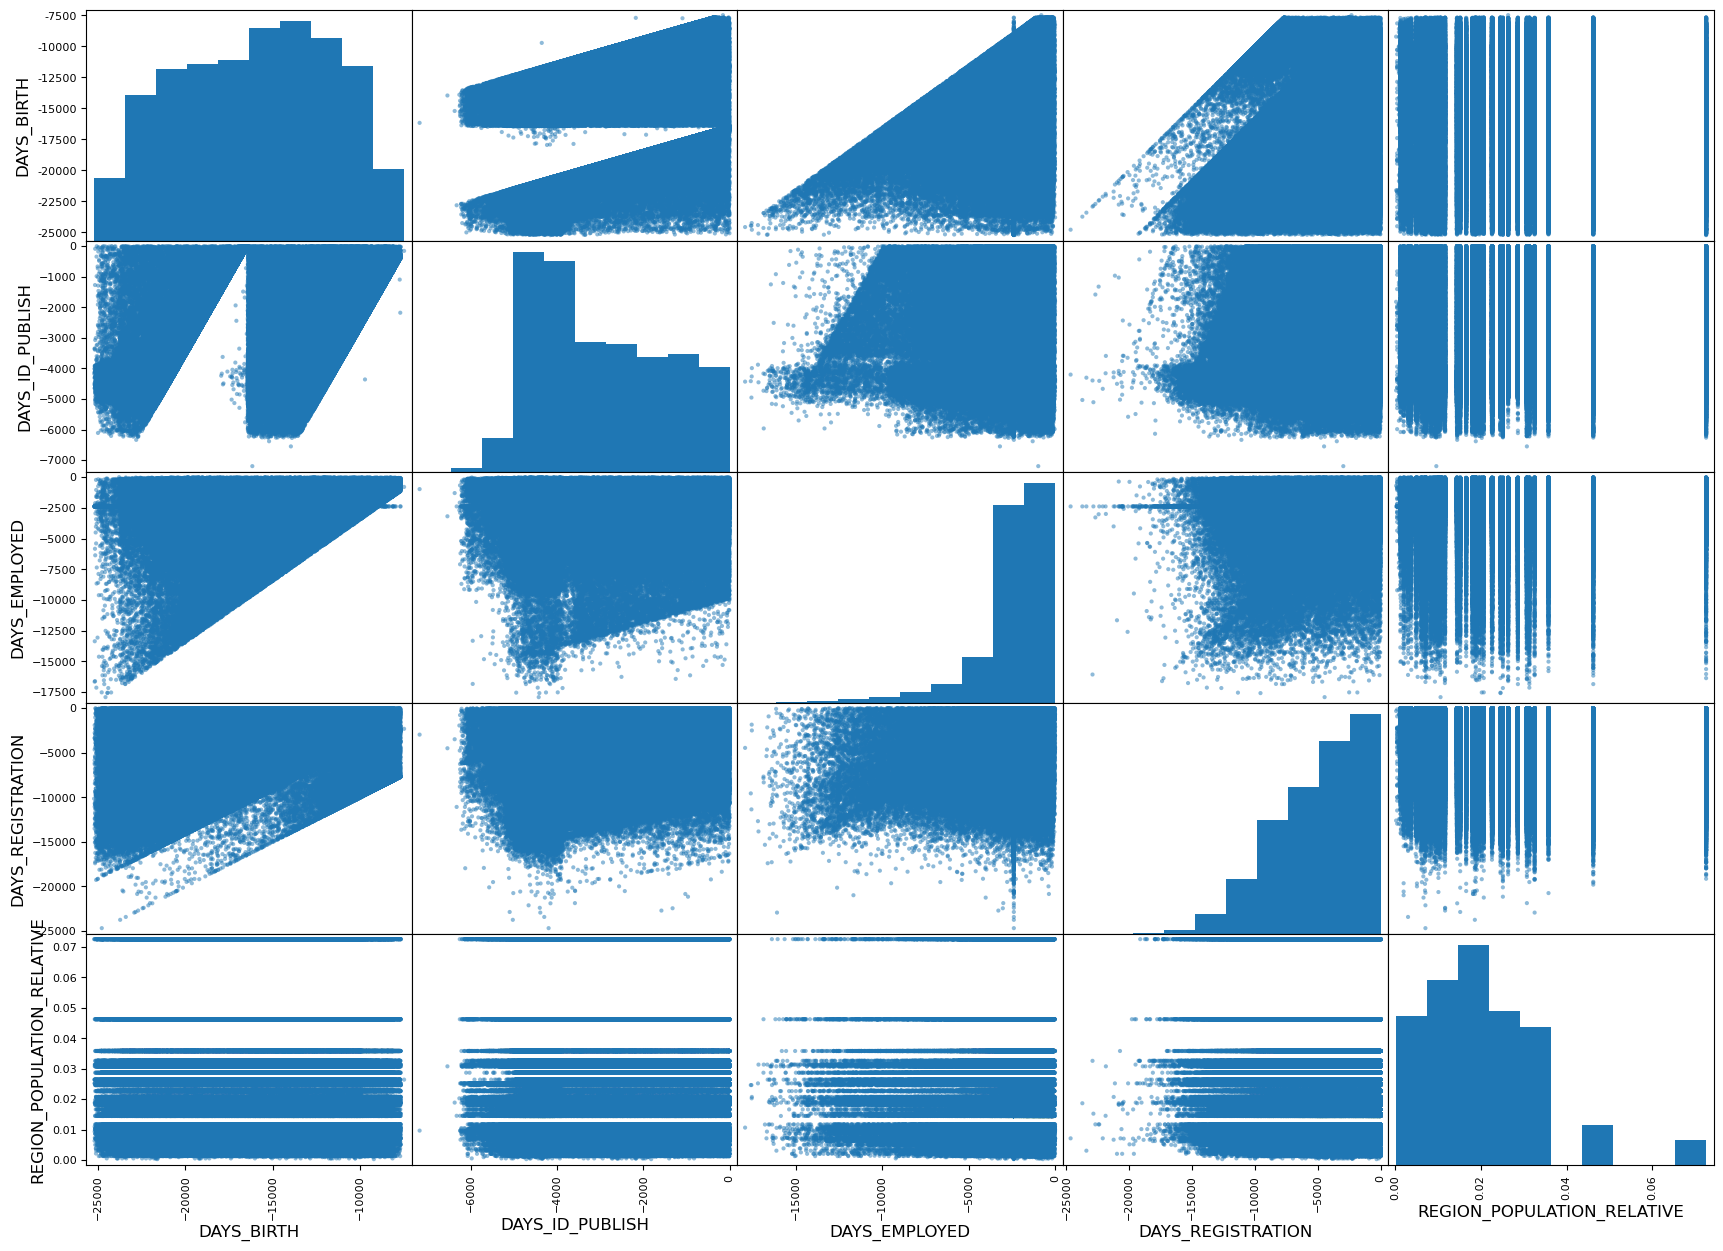

In [17]:
# Nova análise do Top 5
scatter_matrix(df[top5], figsize=(21, 15))
plt.show()

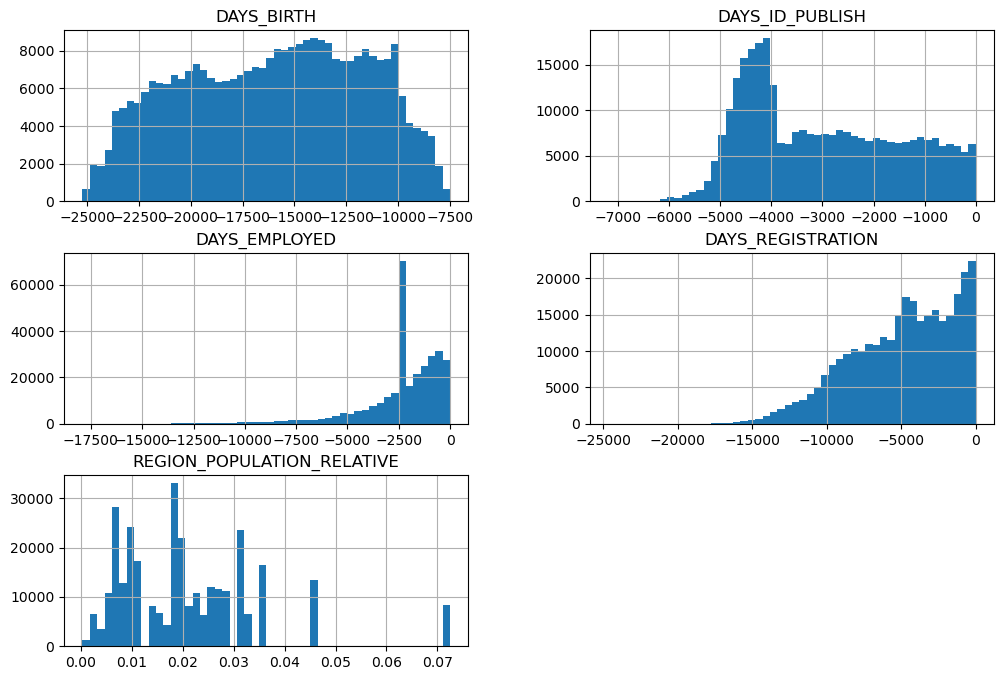

In [18]:
df[top5].hist(bins=50, figsize=(12, 8))
plt.show()

In [19]:
## Vamos usar o pré processamento do scikit-learn para lidar com as colunas categóricas, mas antes,
## vamos ajeitar seus tipos para facilitar
LE = preprocessing.LabelEncoder()
for column in cat:
# Colunas que foram selecionadas manualmente como categóricas
    if column in cat:
        df[column] = LE.fit_transform(df[column].astype(str))